<a href="https://colab.research.google.com/github/rk23aae/Data-Science-Project/blob/main/covid_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Accuracy: 0.5005
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.48      0.32     15757
           1       0.75      0.51      0.60     47603

    accuracy                           0.50     63360
   macro avg       0.49      0.49      0.46     63360
weighted avg       0.62      0.50      0.53     63360

Confusion Matrix:
[[ 7505  8252]
 [23397 24206]]
------------------------------------------------------------
Random Forest Accuracy: 0.4245
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.34      0.23     15757
           1       0.67      0.45      0.54     47603

    accuracy                           0.42     63360
   macro avg       

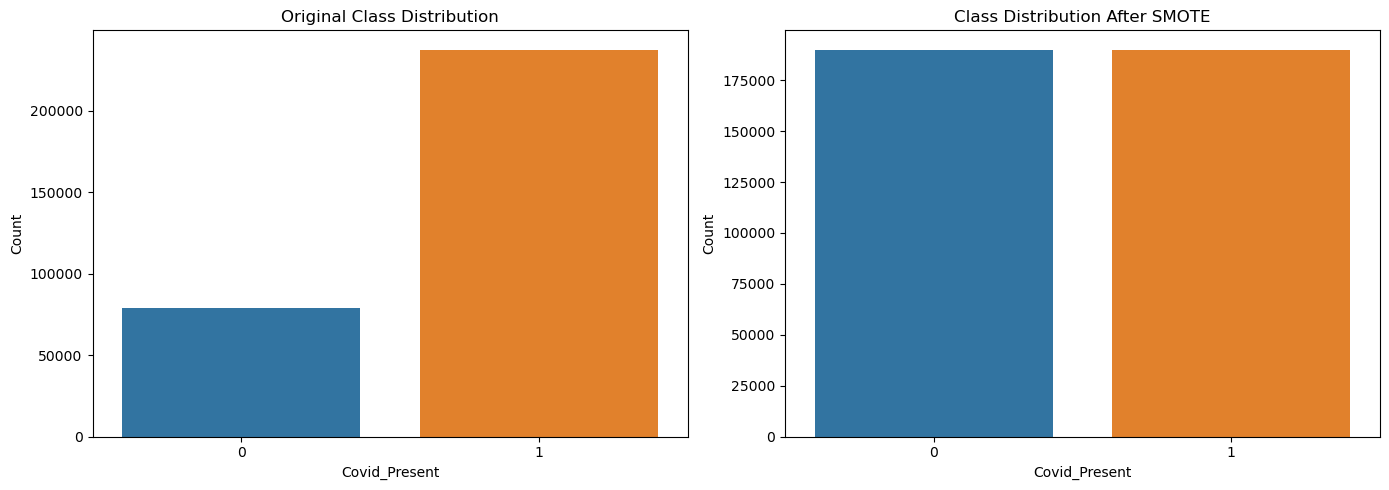

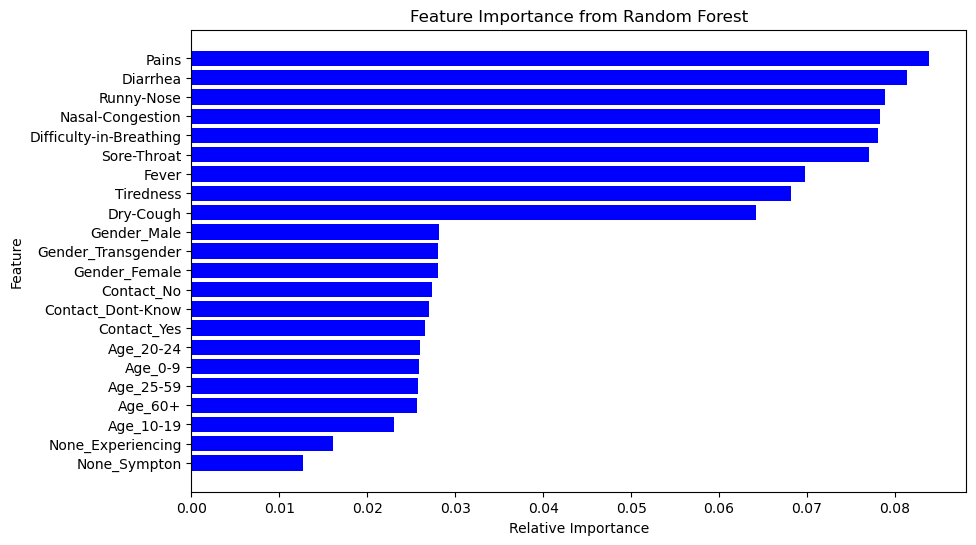

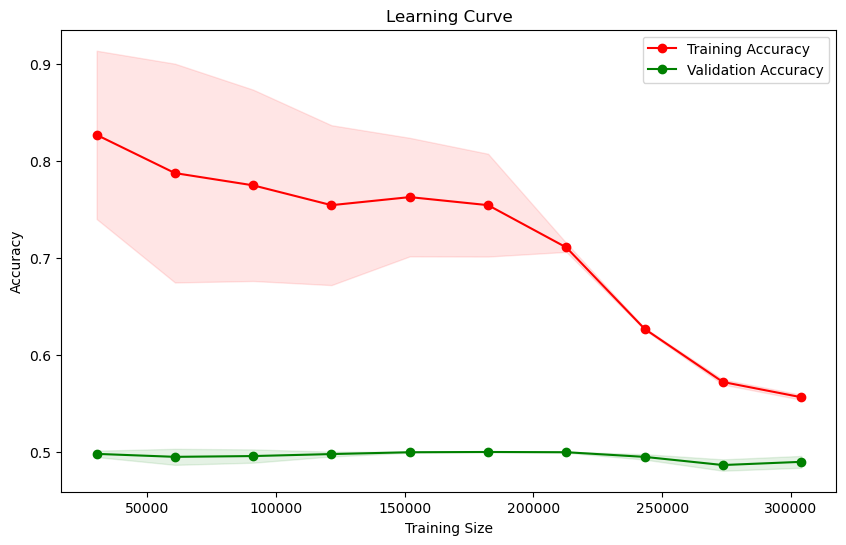

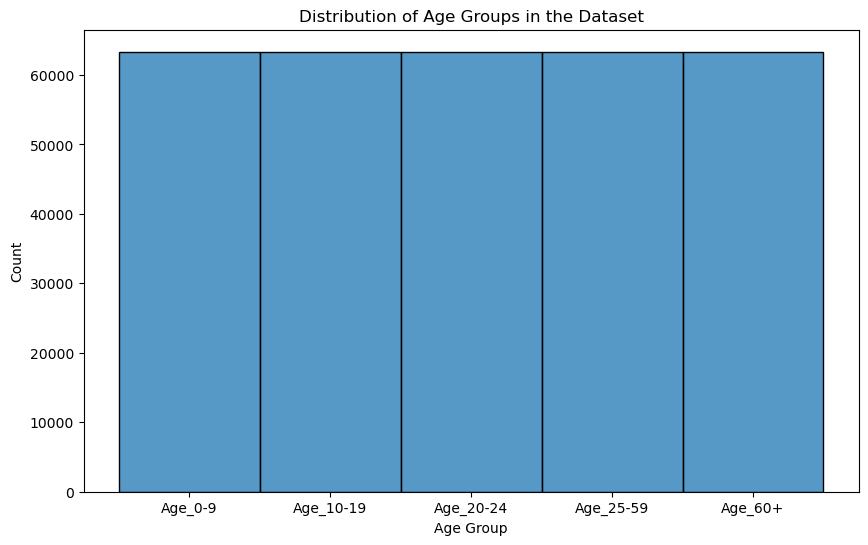

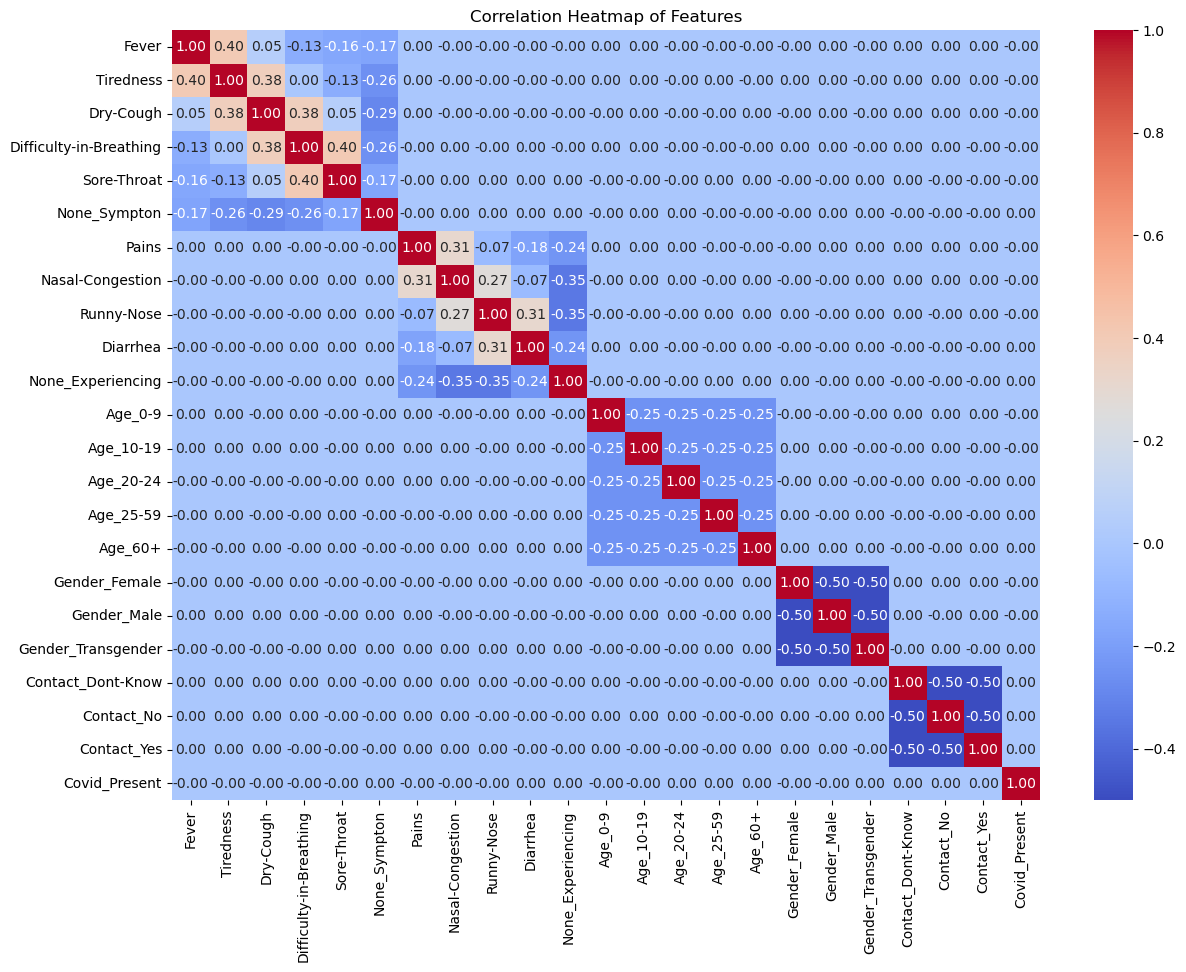

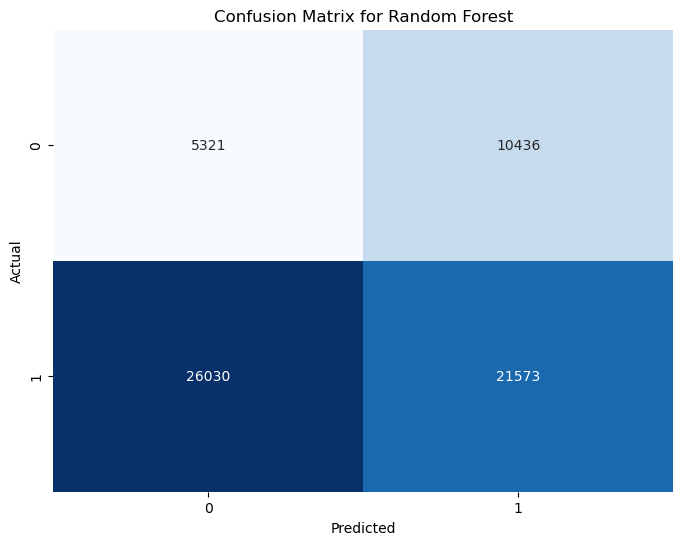

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Define the features (X) and the target (y)
# X = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country', 'Covid_Present'])
X = df['Dry-Cough']
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# Train and evaluate each model
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Visualization of the distribution before and after SMOTE
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1), kde=False)
plt.title("Distribution of Age Groups in the Dataset")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country']).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Manual Confusion Matrix Plot for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import pandas as pd

file_path = '/Cleaned-Data.csv'
df = pd.read_csv(file_path)
print(df.columns)


Index(['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing',
       'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion',
       'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19',
       'Age_20-24', 'Age_25-59', 'Age_60+', 'Gender_Female', 'Gender_Male',
       'Gender_Transgender', 'Severity_Mild', 'Severity_Moderate',
       'Severity_None', 'Severity_Severe', 'Contact_Dont-Know', 'Contact_No',
       'Contact_Yes', 'Country'],
      dtype='object')


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Accuracy: 0.5081
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.47      0.32     15757
           1       0.75      0.52      0.61     47603

    accuracy                           0.51     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.51      0.54     63360

Confusion Matrix:
[[ 7445  8312]
 [22855 24748]]
------------------------------------------------------------
Random Forest Accuracy: 0.5237
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.43      0.31     15757
           1       0.75      0.55      0.64     47603

    accuracy                           0.52     63360
   macro avg       

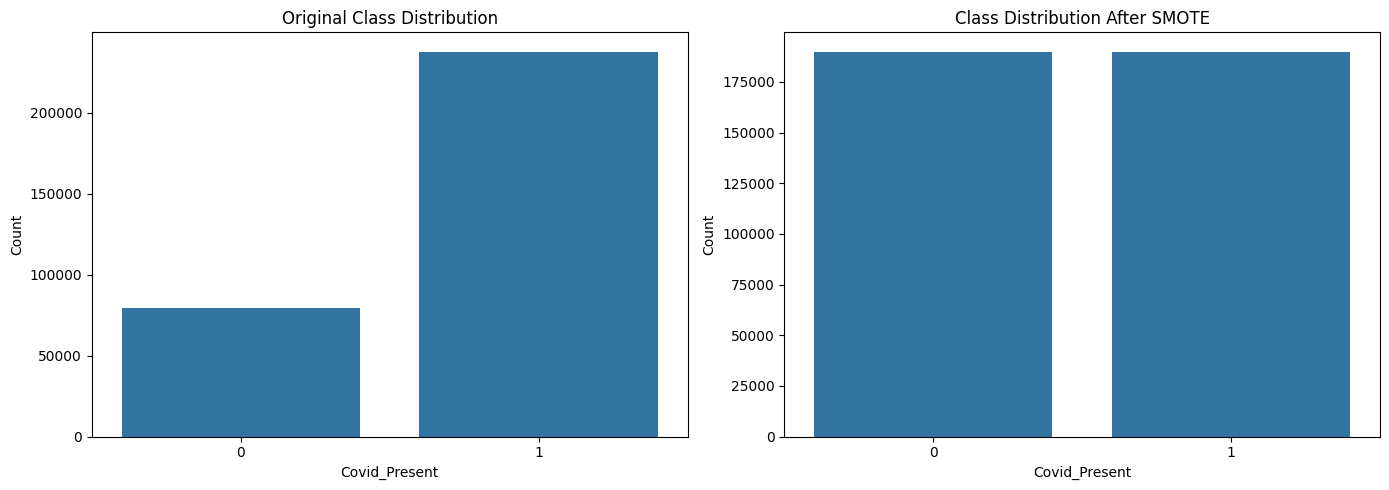

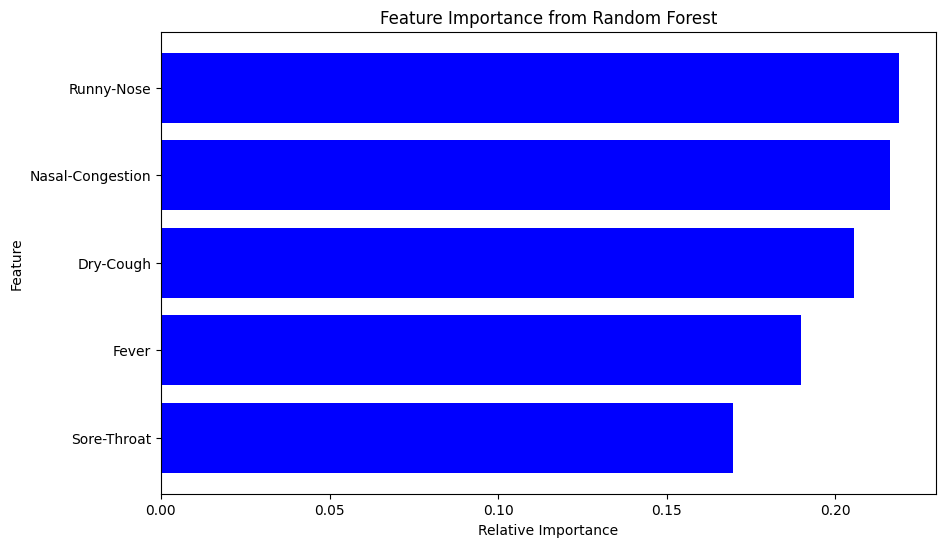

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Define the features (X) and the target (y)
# X = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country', 'Covid_Present'])
X = df[['Fever','Dry-Cough','Sore-Throat','Runny-Nose','Nasal-Congestion']]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# Train and evaluate each model
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Visualization of the distribution before and after SMOTE
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1), kde=False)
plt.title("Distribution of Age Groups in the Dataset")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country']).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Manual Confusion Matrix Plot for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Logistic Regression Accuracy: 0.4921
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.30      0.37     15863
           1       0.49      0.68      0.57     15817

    accuracy                           0.49     31680
   macro avg       0.49      0.49      0.47     31680
weighted avg       0.49      0.49      0.47     31680

Confusion Matrix:
[[ 4769 11094]
 [ 4997 10820]]
------------------------------------------------------------
Random Forest Accuracy: 0.4978
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     15863
           1       0.50      0.48      0.49     15817

    accuracy                           0.50     31680
   macro avg       0.50      0.50      0.50     31680
weighted avg       0.50      0.50      0.50     31680

Confusion Matri

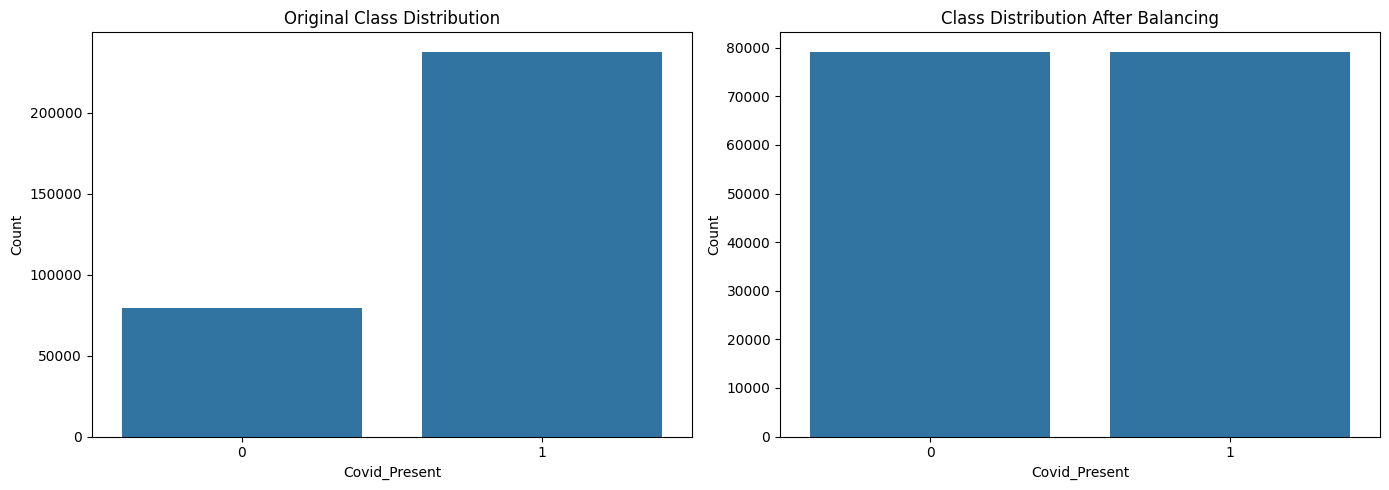

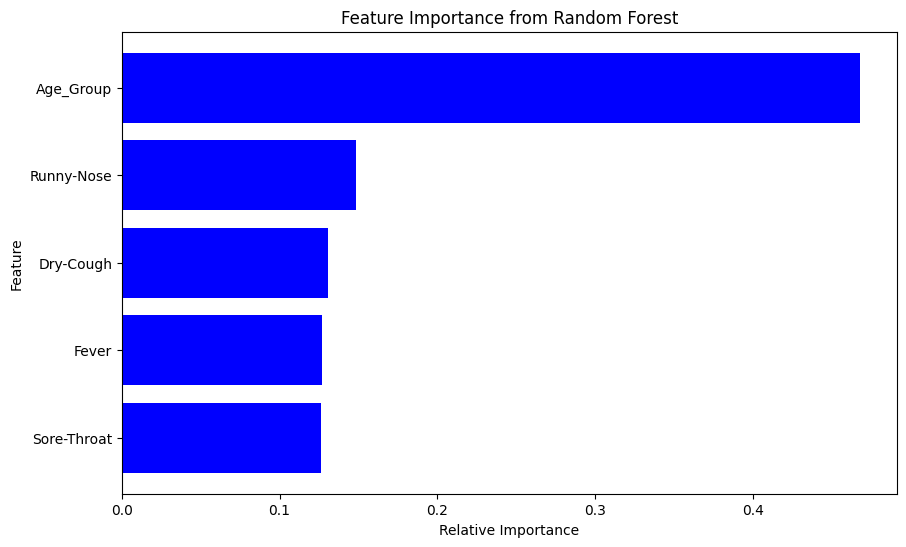

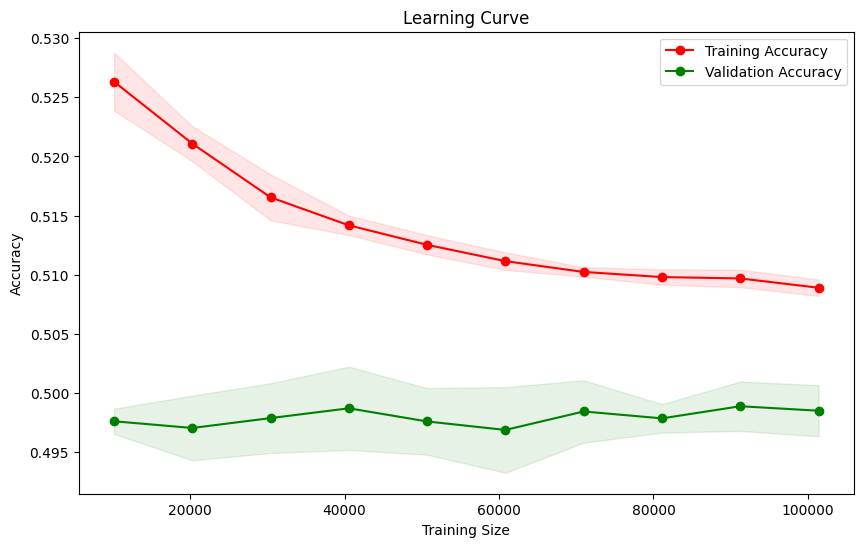

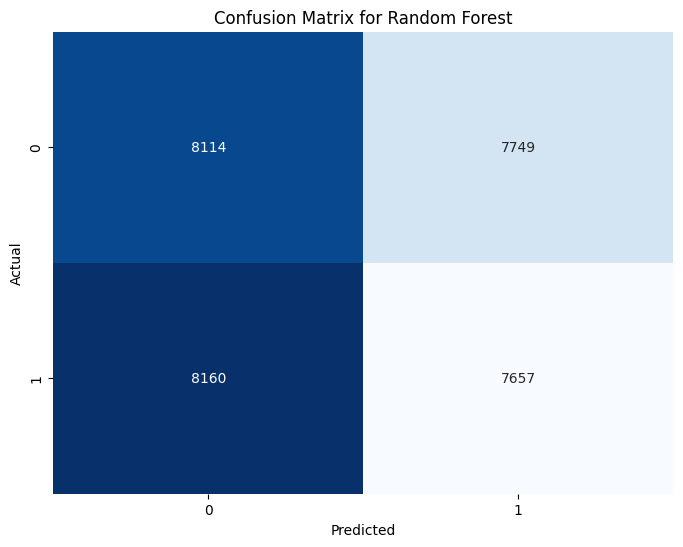

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Load the dataset
file_path = '/var/project/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose', 'Age_Group']]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Combine X and y into a single DataFrame for easier manipulation
df_balanced = pd.concat([X, y], axis=1)

# Identify the majority and minority classes
majority_class = df_balanced[df_balanced['Covid_Present'] == 0]
minority_class = df_balanced[df_balanced['Covid_Present'] == 1]

# Randomly oversample the minority class to match the majority class
minority_class_oversampled = minority_class.sample(len(majority_class), replace=True, random_state=42)

# Combine the majority class with the oversampled minority class
df_balanced = pd.concat([majority_class, minority_class_oversampled])

# Shuffle the DataFrame to mix the classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the balanced dataset into features (X) and target (y)
X_balanced = df_balanced.drop(columns=['Covid_Present'])
y_balanced = df_balanced['Covid_Present']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# Train and evaluate each model
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Visualization of the distribution before and after balancing
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced)
plt.title("Class Distribution After Balancing")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Manual Confusion Matrix Plot for Random Forest
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/var/project/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose']]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# XGBoost
xgb = XGBClassifier(random_state=42)
models.append(('XGBoost', xgb))

# Support Vector Machine
svc = SVC(random_state=42)
models.append(('SVM', svc))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
models.append(('KNN', knn))

# AdaBoost
ada = AdaBoostClassifier(random_state=42)
models.append(('AdaBoost', ada))

# Voting Classifier (Ensemble of the above models)
voting_clf = VotingClassifier(estimators=models, voting='hard')
models.append(('Voting Classifier', voting_clf))

# Train and evaluate each model
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
y_pred_rf = grid_search_rf.predict(X_test)
print("Random Forest Accuracy after tuning: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Classification Report for tuned Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Visualization of the distribution before and after SMOTE
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Learning Curve for tuned Random Forest
train_sizes, train_scores, test_scores = learning_curve(
    grid_search_rf.best_estimator_, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Manual Confusion Matrix Plot for the best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, grid_search_rf.best_estimator_.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Logistic Regression Accuracy: 0.4990
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.31      0.39     47802
           1       0.50      0.69      0.58     47238

    accuracy                           0.50     95040
   macro avg       0.50      0.50      0.48     95040
weighted avg       0.50      0.50      0.48     95040

Confusion Matrix:
[[14911 32891]
 [14724 32514]]
------------------------------------------------------------
Random Forest Accuracy: 0.4972
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41     47802
           1       0.50      0.65      0.56     47238

    accuracy                           0.50     95040
   macro avg       0.50      0.50      0.49     95040
weighted avg       0.50      0.50      0.49     95040

Confusion Matri

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/var/project/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose',]]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# Support Vector Machine
svc = SVC(random_state=42)
models.append(('Support Vector Machine', svc))

# K-Nearest Neighbors
knn = KNeighborsClassifier()
models.append(('K-Nearest Neighbors', knn))



# Train and evaluate each model
results = []
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])

# Plot the model performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Accuracy: 0.5193
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32     15757
           1       0.75      0.54      0.63     47603

    accuracy                           0.52     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.52      0.55     63360

Confusion Matrix:
[[ 7101  8656]
 [21798 25805]]
------------------------------------------------------------
Random Forest Accuracy: 0.5739
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28     15757
           1       0.75      0.65      0.70     47603

    accuracy                           0.57     63360
   macro avg       

Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Accuracy: 0.5081
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.47      0.32     15757
           1       0.75      0.52      0.61     47603

    accuracy                           0.51     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.51      0.54     63360

Confusion Matrix:
[[ 7445  8312]
 [22855 24748]]
------------------------------------------------------------
Random Forest Accuracy: 0.5389
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.40      0.30     15757
           1       0.75      0.59      0.66     47603

    accuracy                           0.54     63360
   macro avg       

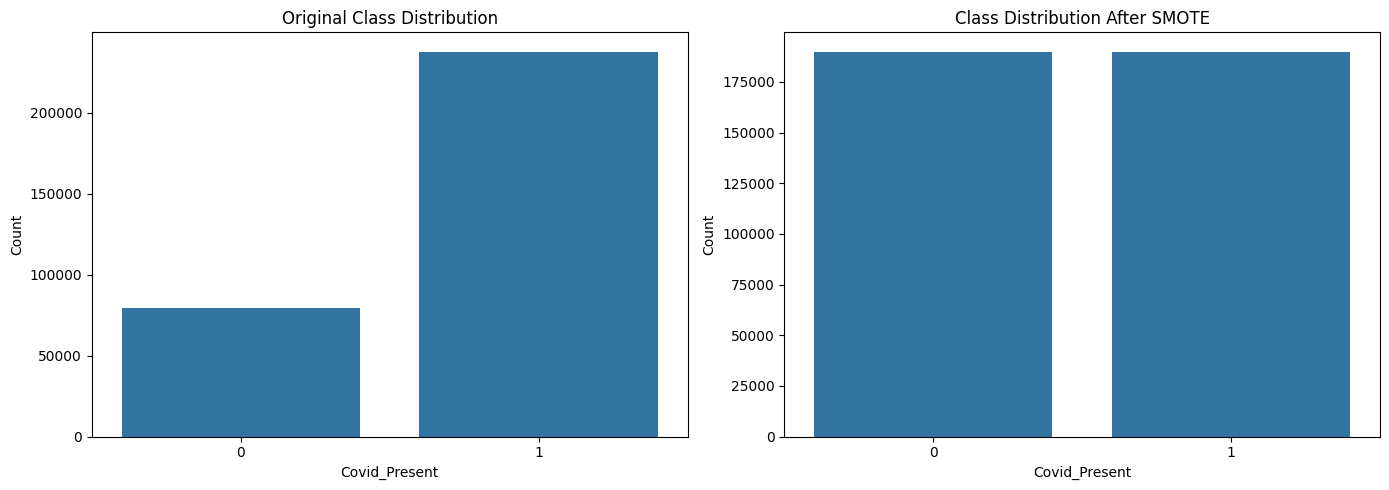

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Define the features (X) and the target (y)
# X = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country', 'Covid_Present'])
X = df[['Fever','Dry-Cough','Sore-Throat','Runny-Nose','Nasal-Congestion','Difficulty-in-Breathing']]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# Train and evaluate each model
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Visualization of the distribution before and after SMOTE
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Covid_Present")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# # Learning Curve
# train_sizes, train_scores, test_scores = learning_curve(
#     RandomForestClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
# )

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
# plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
# plt.title('Learning Curve')
# plt.xlabel('Training Size')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')
# plt.show()

# # Distribution of Age
# plt.figure(figsize=(10, 6))
# sns.histplot(df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1), kde=False)
# plt.title("Distribution of Age Groups in the Dataset")
# plt.xlabel("Age Group")
# plt.ylabel("Count")
# plt.show()

# # Correlation Heatmap
# plt.figure(figsize=(14, 10))
# corr_matrix = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country']).corr()
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title("Correlation Heatmap of Features")
# plt.show()

# # Manual Confusion Matrix Plot for Random Forest
# plt.figure(figsize=(8, 6))
# cm = confusion_matrix(y_test, rf.predict(X_test))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title("Confusion Matrix for Random Forest")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Accuracy: 0.5193
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32     15757
           1       0.75      0.54      0.63     47603

    accuracy                           0.52     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.52      0.55     63360

Confusion Matrix:
[[ 7101  8656]
 [21798 25805]]
------------------------------------------------------------
Random Forest Accuracy: 0.5739
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28     15757
           1       0.75      0.65      0.70     47603

    accuracy                           0.57     63360
   macro avg       

<ipython-input-1-da3c5bd3eae3>:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


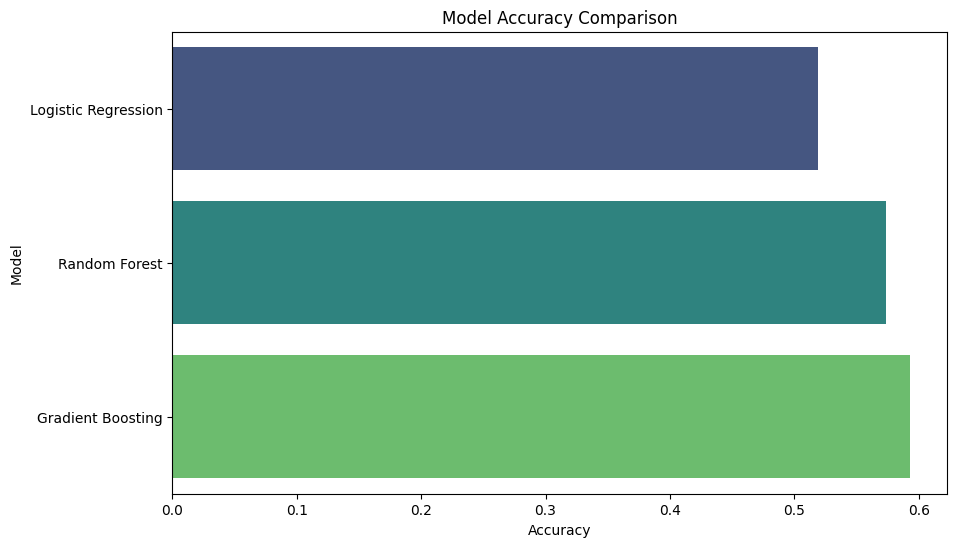

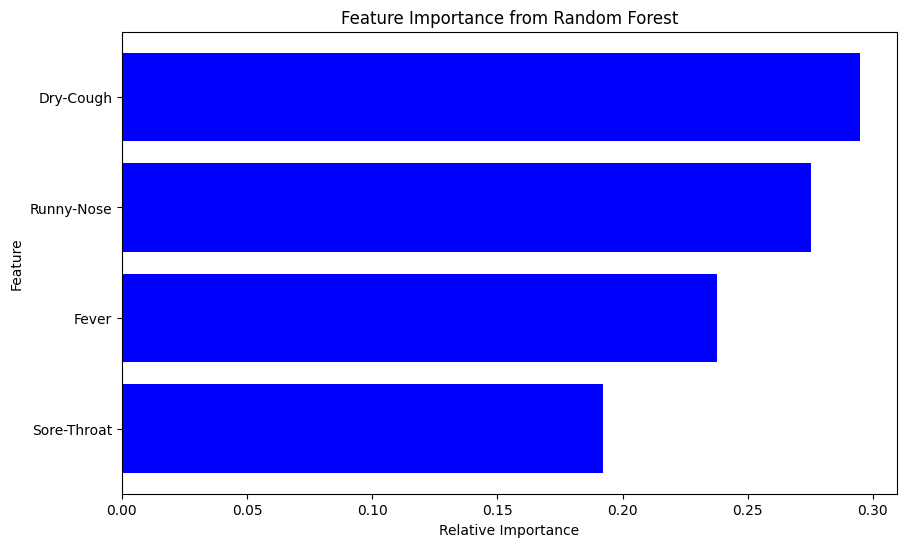

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/var/project/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose',]]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize a list to store models and their results
models = []

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
models.append(('Logistic Regression', logreg))

# Random Forest
rf = RandomForestClassifier(random_state=42)
models.append(('Random Forest', rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
models.append(('Gradient Boosting', gb))

# # Support Vector Machine
# svc = SVC(random_state=42)
# models.append(('Support Vector Machine', svc))

# # K-Nearest Neighbors
# knn = KNeighborsClassifier()
# models.append(('K-Nearest Neighbors', knn))



# Train and evaluate each model
results = []
for name, model in models:
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])

# Plot the model performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Feature Importance from Random Forest
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Performance:
Accuracy: 0.5193
Precision: 0.7488
Recall: 0.5421
F1 Score: 0.6289
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32     15757
           1       0.75      0.54      0.63     47603

    accuracy                           0.52     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.52      0.55     63360

Confusion Matrix:
[[ 7101  8656]
 [21798 25805]]
------------------------------------------------------------
Random Forest Performance:
Accuracy: 0.5739
Precision: 0.7486
Recall: 0.6517
F1 Score: 0.6968
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28     15757
  

<ipython-input-5-6573bd647f95>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=metrics_df, palette='viridis')


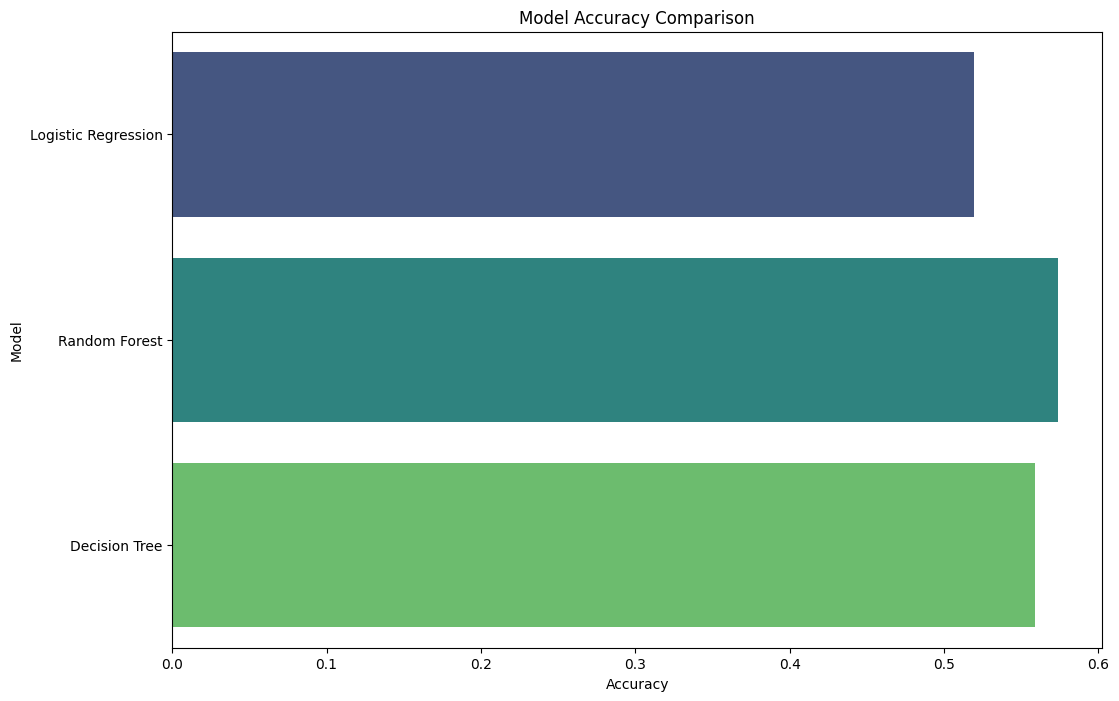

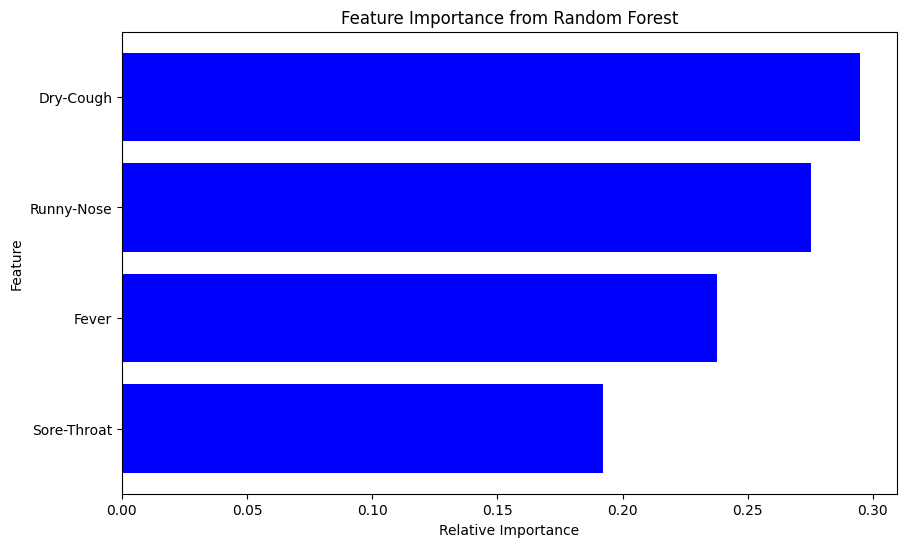

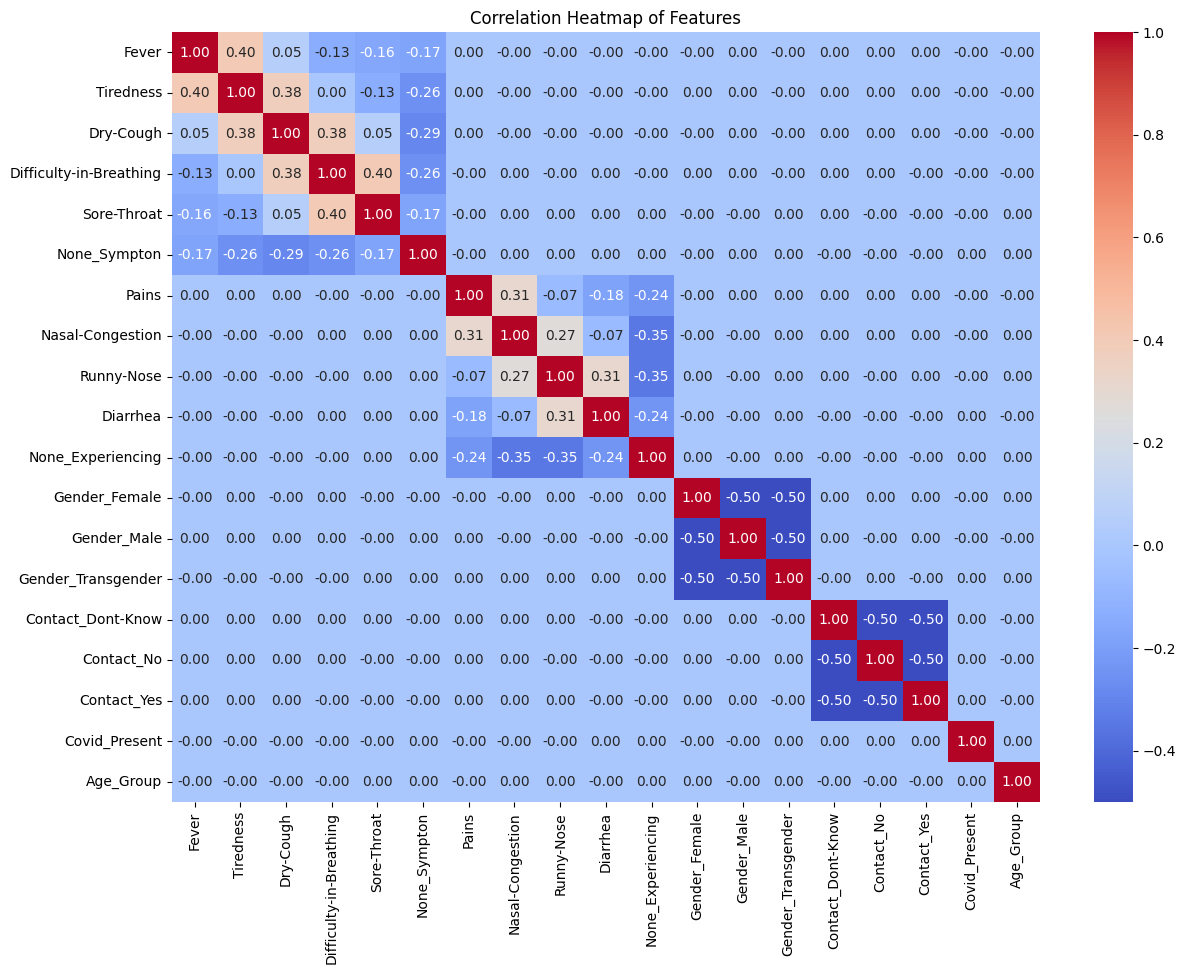

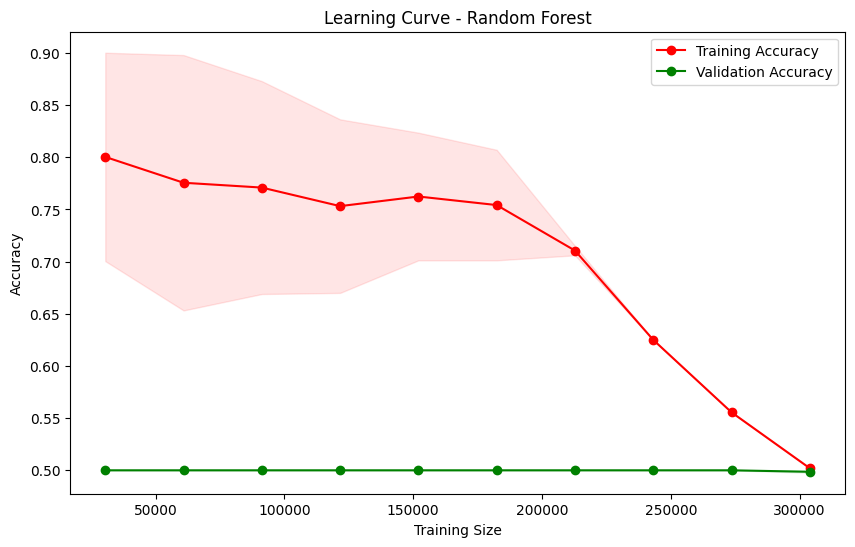

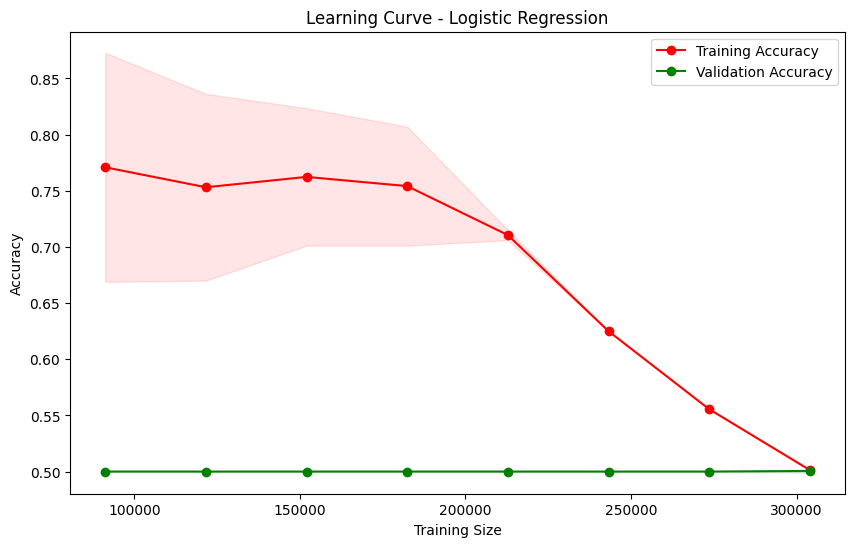

<ipython-input-5-6573bd647f95>:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy', 'Precision', 'F1 Score'], y=[log_reg_metrics['Accuracy'].values[0],


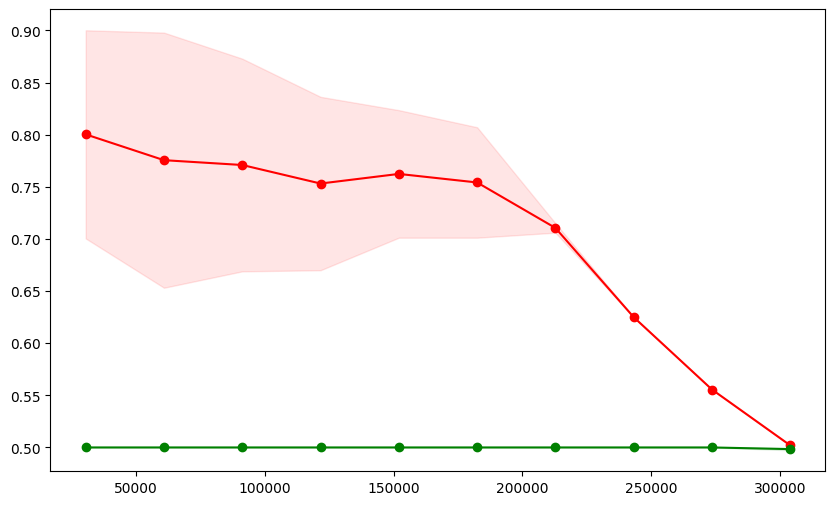

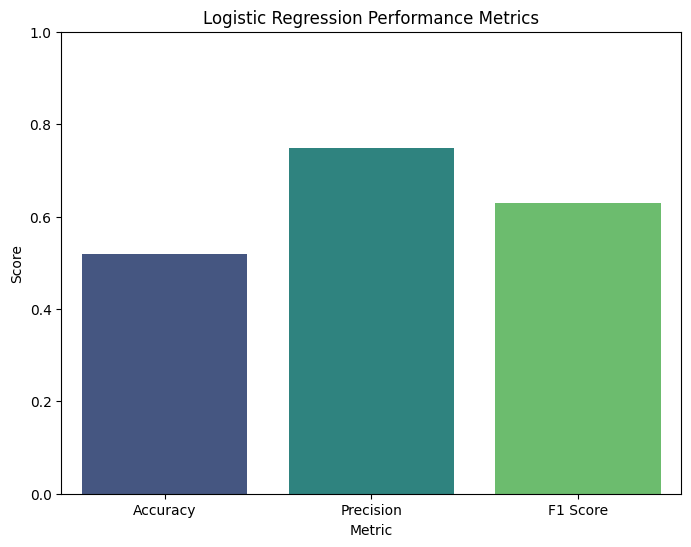

<ipython-input-5-6573bd647f95>:238: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')


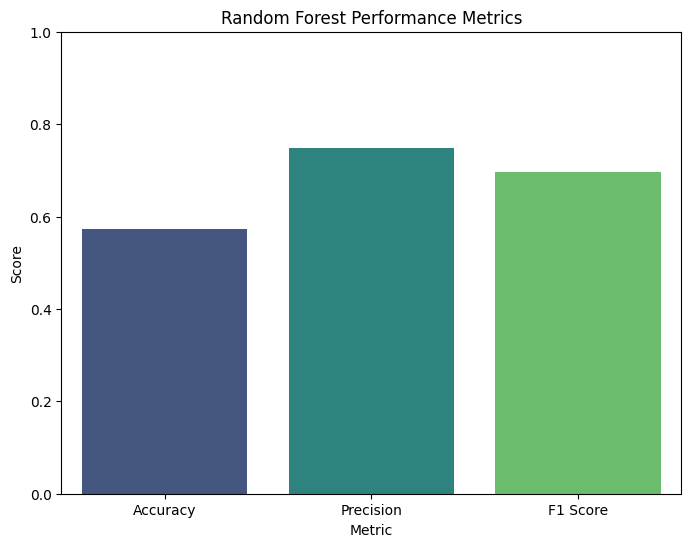

<ipython-input-5-6573bd647f95>:259: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')


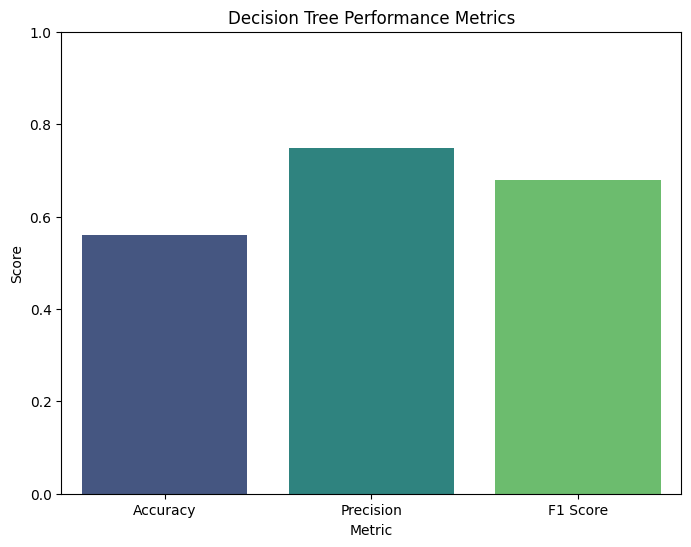

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

# Load the dataset
file_path = '/var/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose']]
y = df['Covid_Present']

# Check the distribution of the target variable
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
metrics = []
for name, model in models.items():
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Convert metrics to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot the model performance
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=metrics_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# # Plot precision, recall, and F1 score
# plt.figure(figsize=(15, 8))
# metrics_df.set_index('Model').plot(kind='bar', figsize=(15, 8))
# plt.title('Precision, Recall, and F1 Score Comparison')
# plt.ylabel('Score')
# plt.xlabel('Model')
# plt.show()

# Feature Importance from Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country']).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Learning Curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Learning Curves for Logistic Regression
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000, random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Learning Curves for Decision Tree
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)


# Extract the Logistic Regression metrics from the 'metrics' DataFrame
log_reg_metrics = metrics_df[metrics_df['Model'] == 'Logistic Regression']

# Plot the metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=['Accuracy', 'Precision', 'F1 Score'], y=[log_reg_metrics['Accuracy'].values[0],
                                                        log_reg_metrics['Precision'].values[0],
                                                        log_reg_metrics['F1 Score'].values[0]],
            palette='viridis')

plt.title('Logistic Regression Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()


# Extract the Random Forest metrics from the 'metrics_df' DataFrame
rf_metrics = metrics_df[metrics_df['Model'] == 'Random Forest']

# Extract the specific metrics
metrics_values = [rf_metrics['Accuracy'].values[0],
                  rf_metrics['Precision'].values[0],
                  rf_metrics['F1 Score'].values[0]]

# Define the metric labels
metrics_labels = ['Accuracy', 'Precision', 'F1 Score']

# Plot the metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')

plt.title('Random Forest Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()

# Extract the Decision Tree metrics from the 'metrics_df' DataFrame
dt_metrics = metrics_df[metrics_df['Model'] == 'Decision Tree']

# Extract the specific metrics
metrics_values = [dt_metrics['Accuracy'].values[0],
                  dt_metrics['Precision'].values[0],
                  dt_metrics['F1 Score'].values[0]]

# Define the metric labels
metrics_labels = ['Accuracy', 'Precision', 'F1 Score']

# Plot the metrics
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')

plt.title('Decision Tree Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()


Class distribution in the target variable:
Covid_Present
1    237600
0     79200
Name: count, dtype: int64
Class distribution after applying SMOTE:
Covid_Present
1    189997
0    189997
Name: count, dtype: int64
Logistic Regression Performance:
Accuracy: 0.5193
Precision: 0.7488
Recall: 0.5421
F1 Score: 0.6289
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.45      0.32     15757
           1       0.75      0.54      0.63     47603

    accuracy                           0.52     63360
   macro avg       0.50      0.50      0.47     63360
weighted avg       0.62      0.52      0.55     63360

Confusion Matrix:
[[ 7101  8656]
 [21798 25805]]
------------------------------------------------------------
Random Forest Performance:
Accuracy: 0.5739
Precision: 0.7486
Recall: 0.6517
F1 Score: 0.6968
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28     15757
  

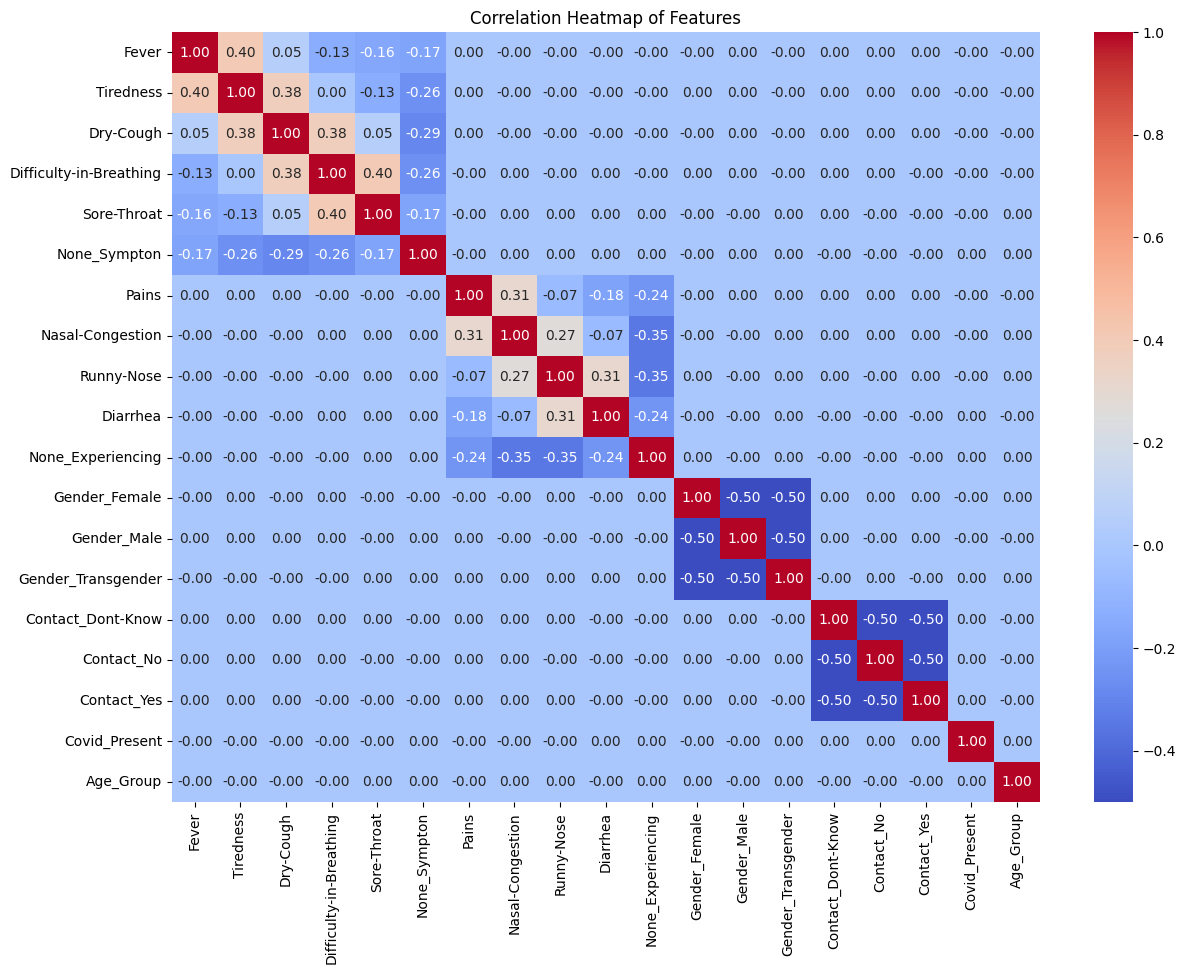

<ipython-input-6-6909f0ca1938>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=metrics_df, palette='viridis')


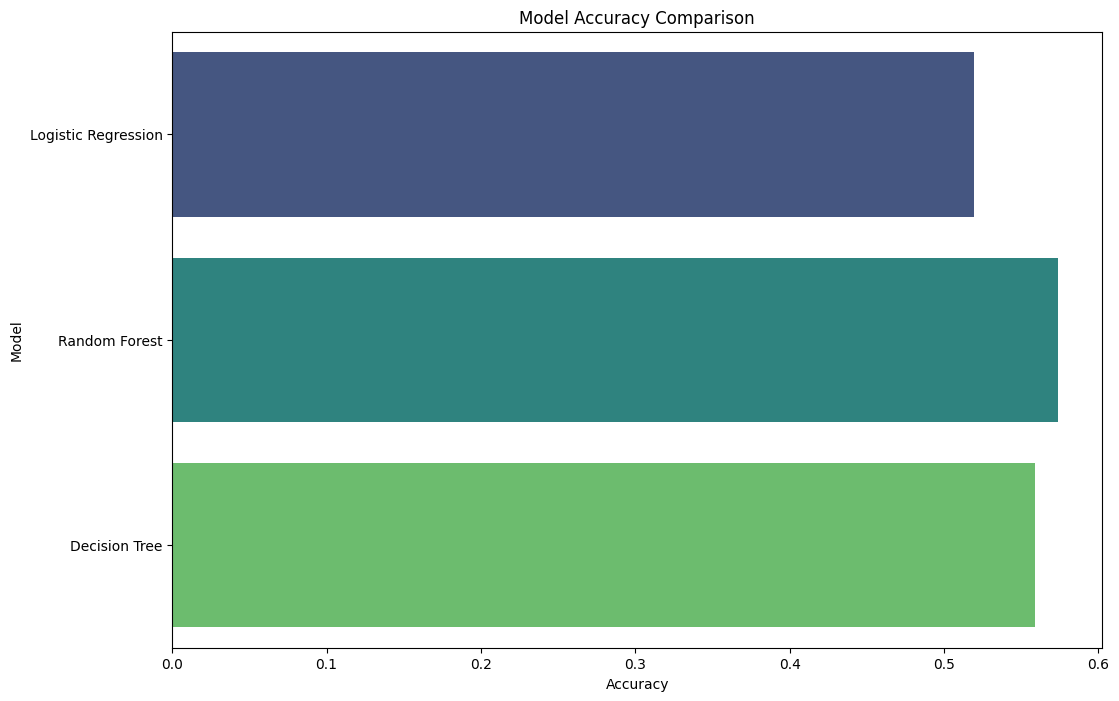

<ipython-input-6-6909f0ca1938>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Accuracy', 'Precision', 'F1 Score'], y=[log_reg_metrics['Accuracy'].values[0],


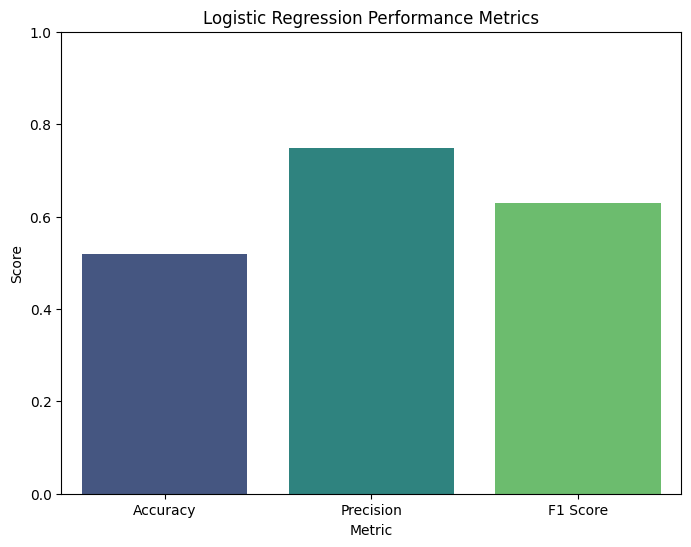

<ipython-input-6-6909f0ca1938>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')


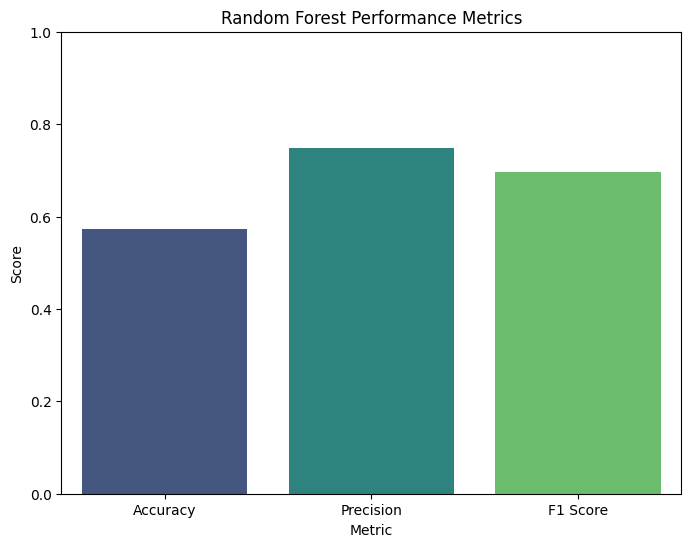

<ipython-input-6-6909f0ca1938>:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')


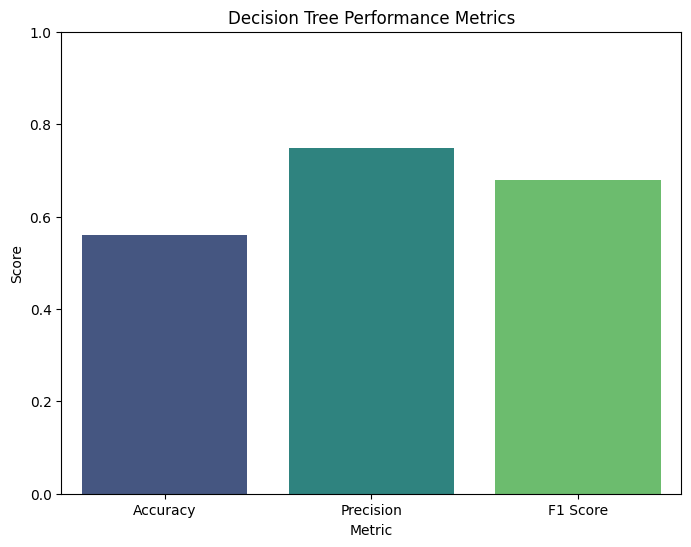

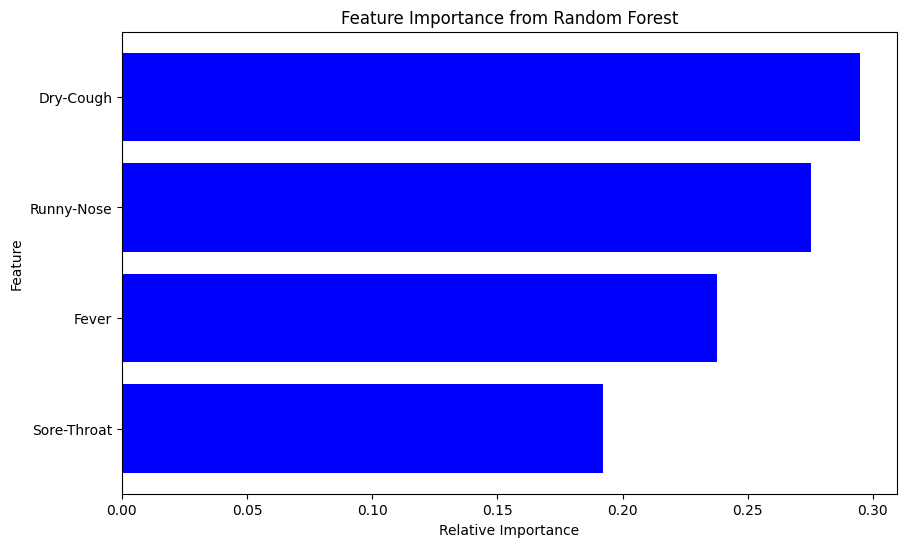

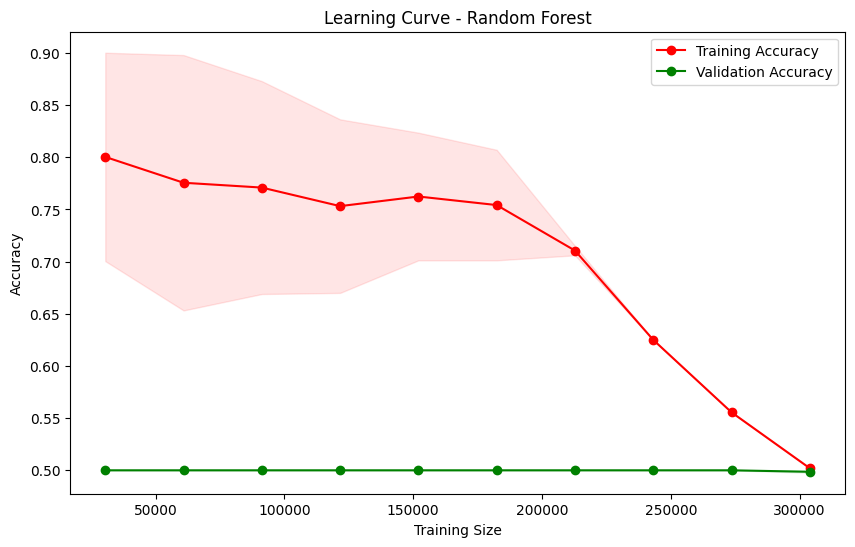

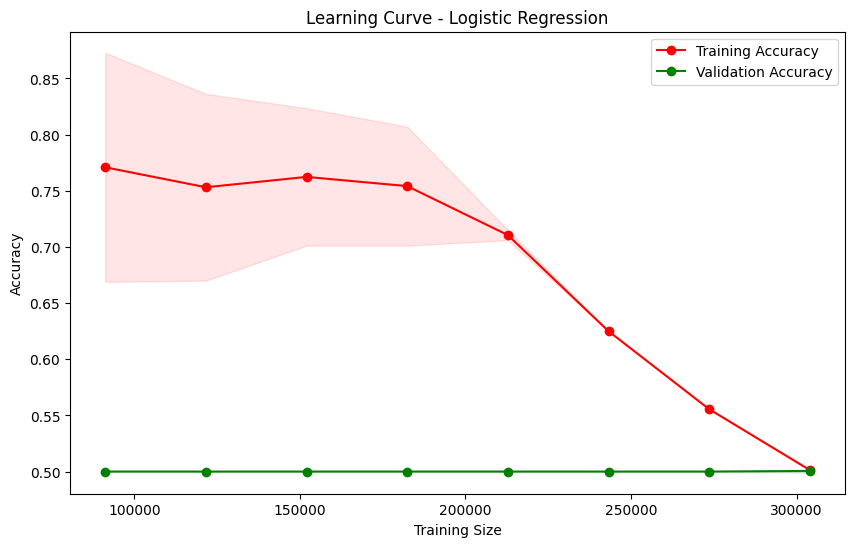

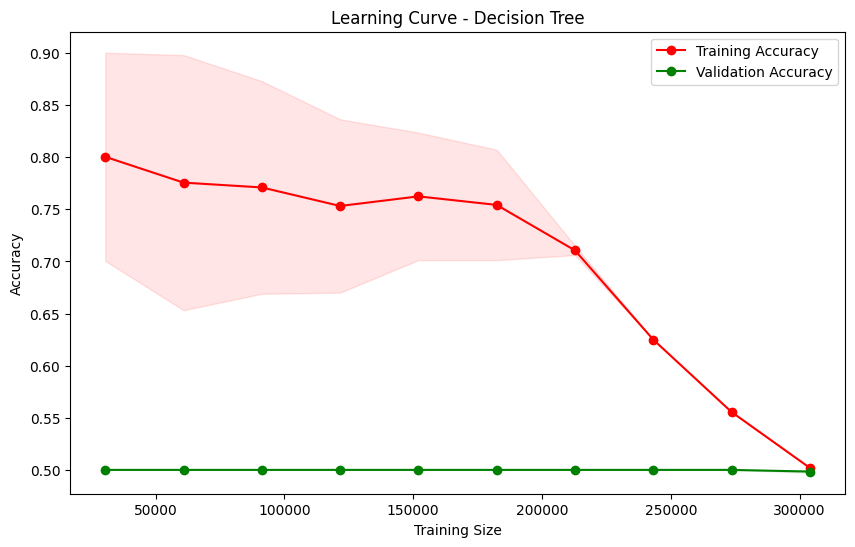

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

# Load the dataset
file_path = '/var/Cleaned-Data.csv'
df = pd.read_csv(file_path)

# Create the target variable 'Covid_Present'
# This variable indicates whether a person has COVID-19 (1) or not (0)
df['Covid_Present'] = df[['Severity_Mild', 'Severity_Moderate', 'Severity_Severe']].max(axis=1)

# Create a new column 'Age_Group' where each age group is represented by a numerical category
# This helps in simplifying the age-related data for model processing
age_mapping = {
    'Age_0-9': 1,
    'Age_10-19': 2,
    'Age_20-24': 3,
    'Age_25-59': 4,
    'Age_60+': 5
}

# Apply the mapping to create the 'Age_Group' column
df['Age_Group'] = df[['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']].idxmax(axis=1).map(age_mapping)

# Drop the original age columns as they are now represented in the 'Age_Group' column
df.drop(columns=['Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+'], inplace=True)

# Define the features (X) and the target (y)
# Features include symptoms while the target is the presence of COVID-19
X = df[['Fever', 'Dry-Cough', 'Sore-Throat', 'Runny-Nose']]
y = df['Covid_Present']

# Check the distribution of the target variable to understand class imbalance
print("Class distribution in the target variable:")
print(y.value_counts())

# Split the dataset into training and testing sets
# The test size is 20% of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
# SMOTE generates synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling to ensure balance
print("Class distribution after applying SMOTE:")
print(y_train_resampled.value_counts())

# Initialize models for comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
metrics = []
for name, model in models.items():
    # Create a pipeline to scale features and apply the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardizes the data
        ('classifier', model)  # Applies the model
    ])

    # Train the model
    pipeline.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the metrics for later comparison
    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Print the evaluation results
    print(f"{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

# Convert metrics to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Correlation Heatmap
# This plot shows the correlation between different features in the dataset
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Severity_Mild', 'Severity_Moderate', 'Severity_Severe', 'Severity_None', 'Country']).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

# Plot the model performance (Accuracy)
# This bar plot compares the accuracy of the different models
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=metrics_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Plot Logistic Regression metrics
# Visualizes the key metrics for the Logistic Regression model
log_reg_metrics = metrics_df[metrics_df['Model'] == 'Logistic Regression']

plt.figure(figsize=(8, 6))
sns.barplot(x=['Accuracy', 'Precision', 'F1 Score'], y=[log_reg_metrics['Accuracy'].values[0],
                                                        log_reg_metrics['Precision'].values[0],
                                                        log_reg_metrics['F1 Score'].values[0]],
            palette='viridis')

plt.title('Logistic Regression Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()

# Plot Random Forest metrics
# Visualizes the key metrics for the Random Forest model
rf_metrics = metrics_df[metrics_df['Model'] == 'Random Forest']

metrics_values = [rf_metrics['Accuracy'].values[0],
                  rf_metrics['Precision'].values[0],
                  rf_metrics['F1 Score'].values[0]]

metrics_labels = ['Accuracy', 'Precision', 'F1 Score']

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')

plt.title('Random Forest Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()

# Plot Decision Tree metrics
# Visualizes the key metrics for the Decision Tree model
dt_metrics = metrics_df[metrics_df['Model'] == 'Decision Tree']

metrics_values = [dt_metrics['Accuracy'].values[0],
                  dt_metrics['Precision'].values[0],
                  dt_metrics['F1 Score'].values[0]]

metrics_labels = ['Accuracy', 'Precision', 'F1 Score']

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_labels, y=metrics_values, palette='viridis')

plt.title('Decision Tree Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensures the y-axis ranges from 0 to 1 for better comparison
plt.xlabel('Metric')
plt.show()

# Feature Importance from Random Forest
# Shows the importance of each feature in the Random Forest model
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance from Random Forest")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

# Learning Curves for Random Forest
# Plots learning curves to show how the model's performance changes with more training data
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Learning Curves for Logistic Regression
# Plots learning curves to show how the model's performance changes with more training data
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000, random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve - Logistic Regression')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Learning Curves for Decision Tree
# Plots learning curves to show how the model's performance changes with more training data
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(random_state=42), X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.title('Learning Curve - Decision Tree')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

#----------------